# EDA

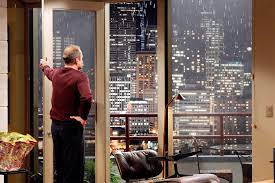

## Research questions and hypotheses

1. Impact of living space on price?

    **Hypothesis**: The bigger the sqft area, the higher the price

2. Impact of waterfront on price?

    **Hypothesis**: If waterfront, then higher price

3. Influence of location on house price?

    **Hypothesis**: 
    - Higher avg house prices for specific neighborhoods/regions
    - if located to water, then higher prices </br>
    &rarr; higher avg prices the more to the west

In [2]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
import psycopg2
import os
from dotenv import load_dotenv

load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

# Create connection object conn
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

cur = conn.cursor()

sql_query_fetch_all_data = """
    SELECT kchd.*,kchs."date", kchs.price 
    FROM eda.king_county_house_details kchd 
    LEFT JOIN eda.king_county_house_sales kchs 
    ON kchd.id = kchs.house_id;
"""

cur.execute(sql_query_fetch_all_data)
cur.fetchall()

df_all = pd.read_sql(sql_query_fetch_all_data, conn)

#close the connection
conn.close()


df_all.to_csv('data/merged_data.csv',index=False)

## First inspection of the data

In [4]:
import pandas as pd
df_kch = pd.read_csv('data/merged_data.csv')

print(df_kch.shape)
df_kch.info()

(21597, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64

## Data cleaning: Check for duplicates, missing data and outliers

### Checking for duplicates

In [4]:
#1. checking for duplicates in the data: there are none
df_kch.duplicated().value_counts()


False    21597
Name: count, dtype: int64

### Checking for missing data

In [6]:
#2. missing data handling
# import missingno to search for missing values
import missingno as msno

df_kch.isna().sum()

id               0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
date             0
price            0
dtype: int64

<Axes: >

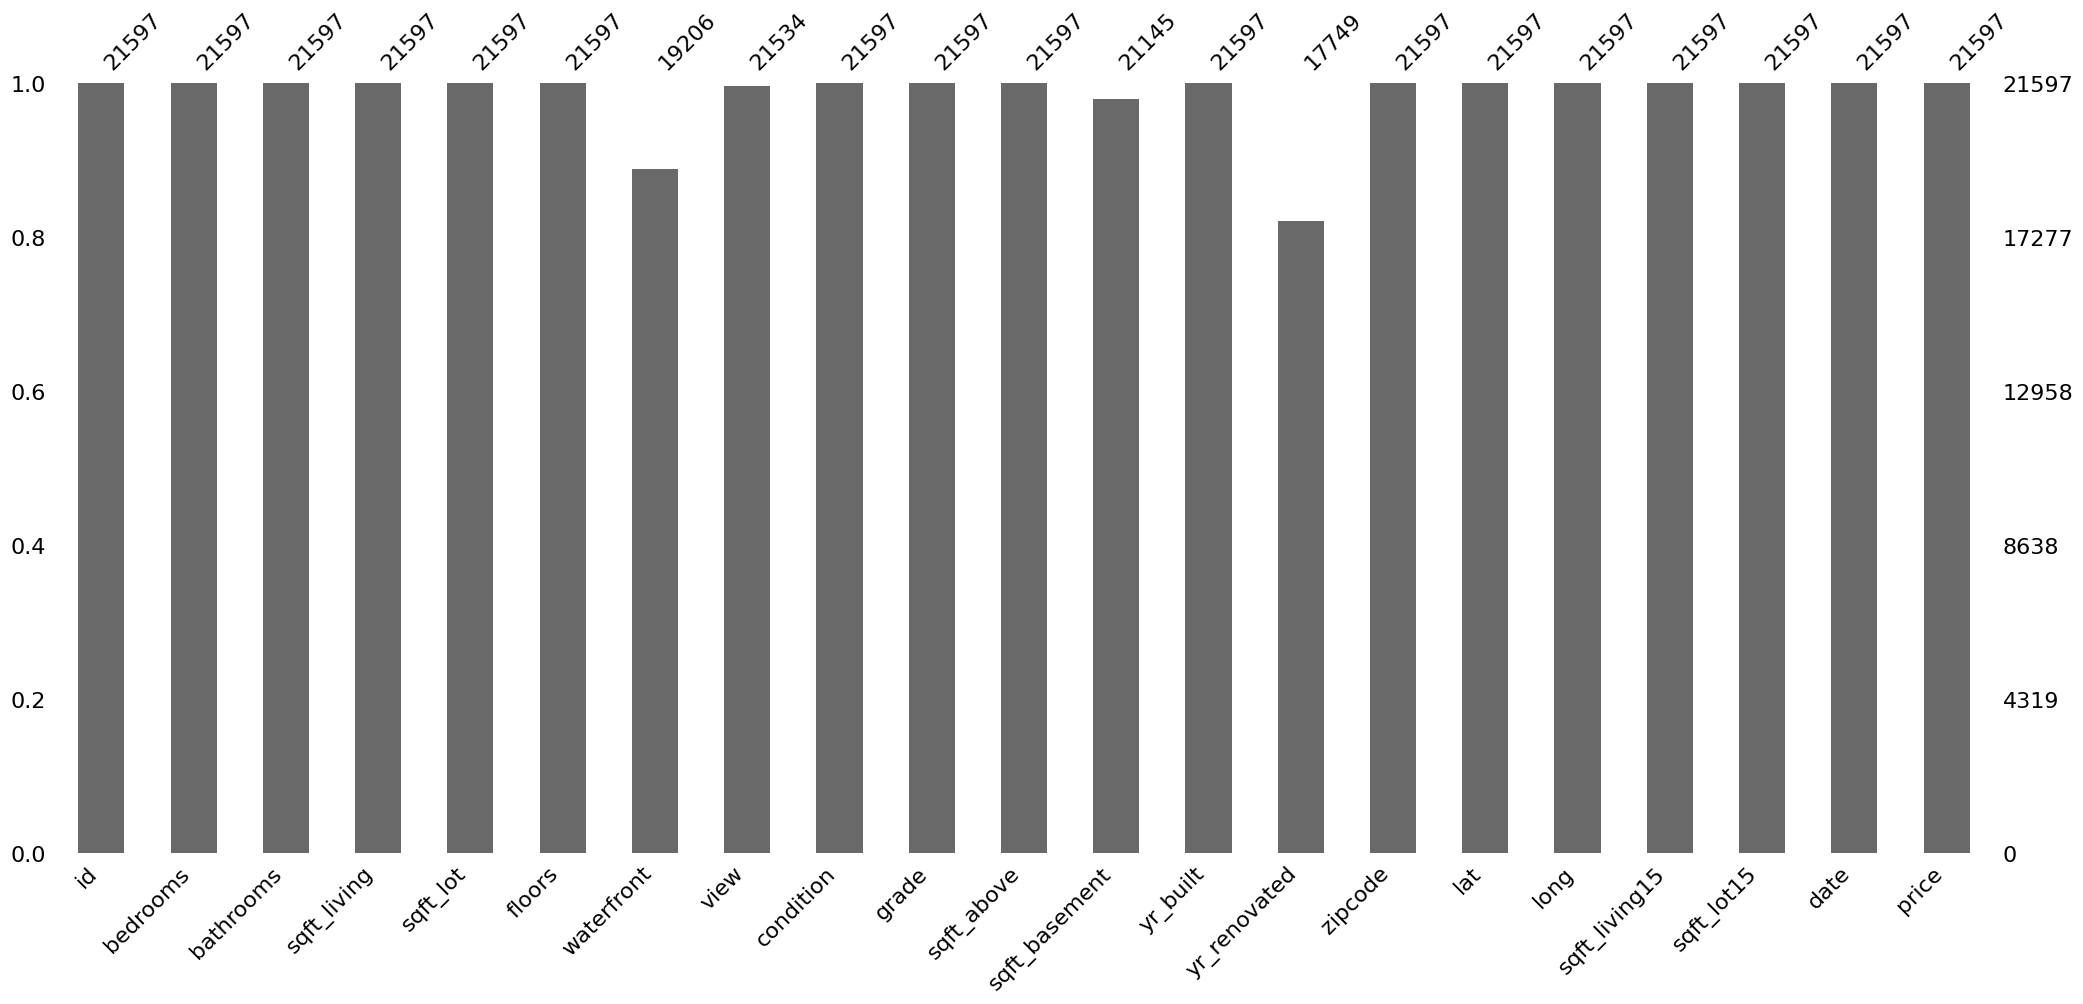

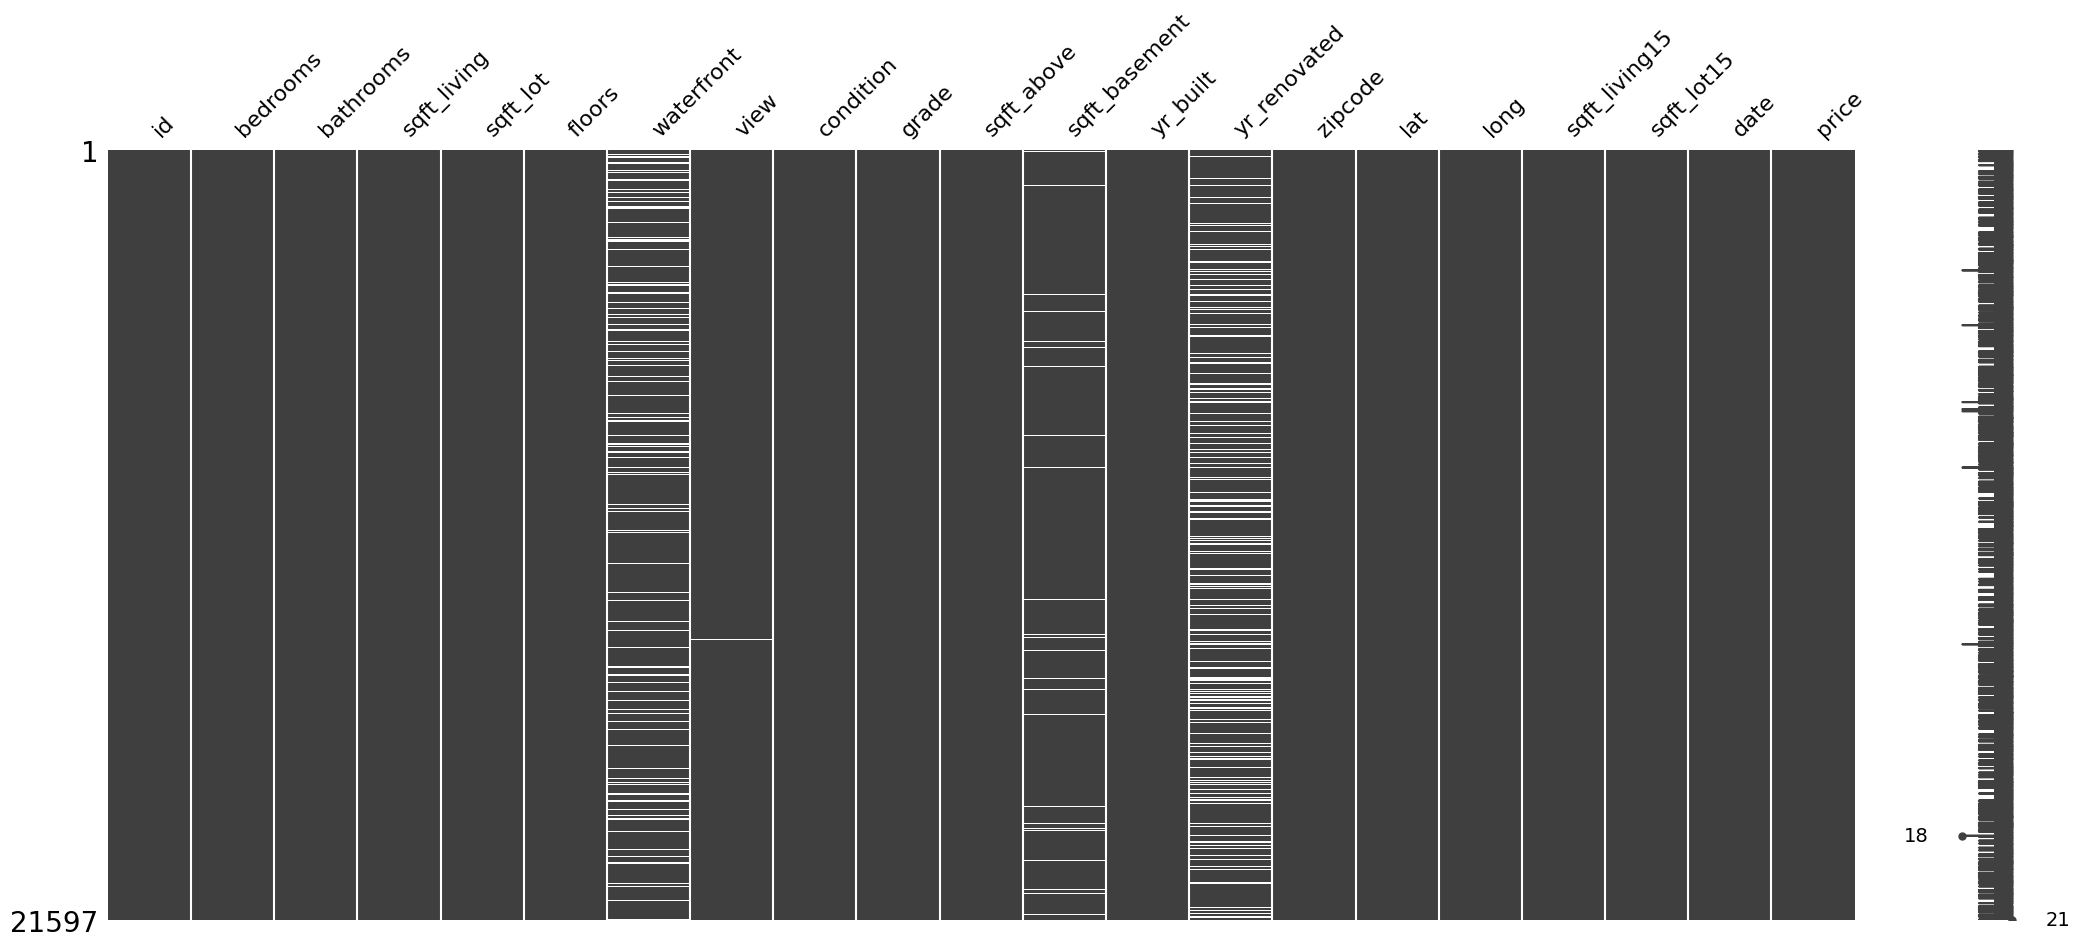

In [6]:
msno.bar(df_kch)
msno.matrix(df_kch)

### Data Imputation

We have several missing values in the columns waterfront, view, sqft_basement and yr_renovated.
After a look into the dataset and column descriptions, I assume that missing entries mean that they have none (no waterfront, view, basement and no renovation).
Hence I decide to fill them with a zero.

<Axes: >

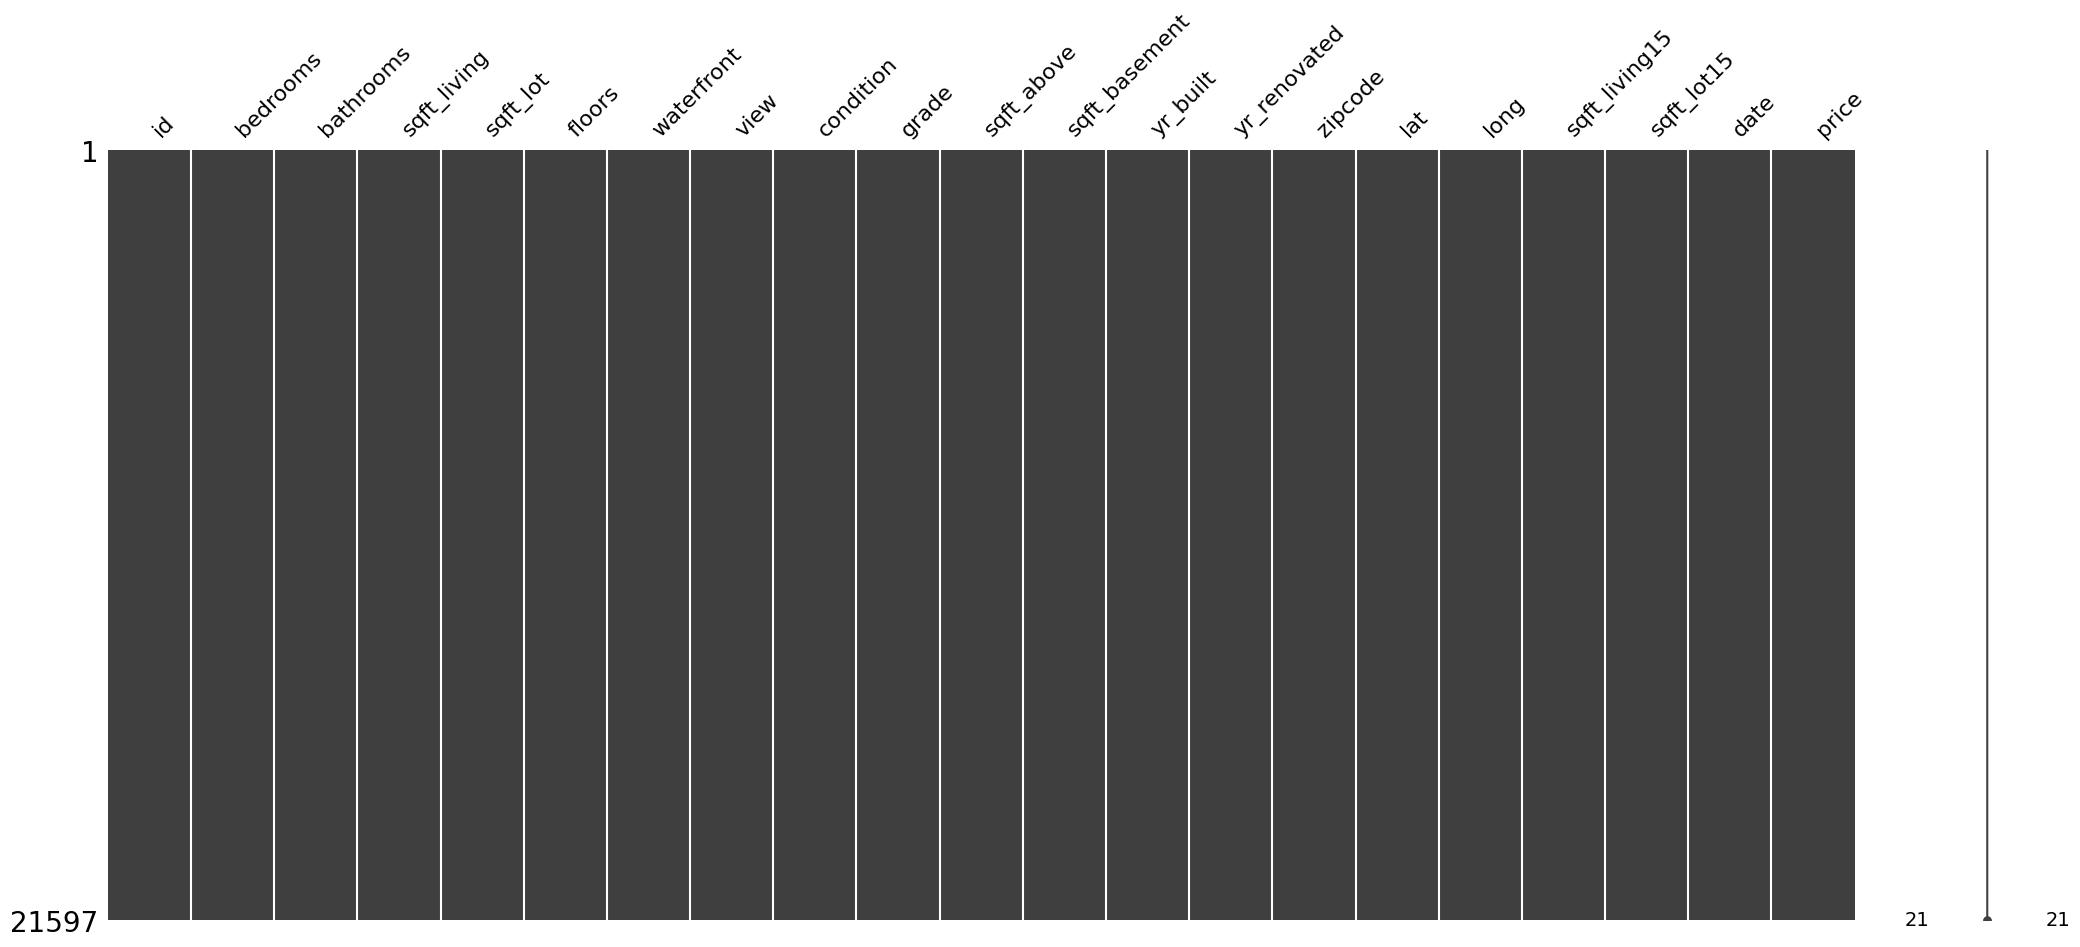

In [7]:
for col in ['waterfront', 'view', 'sqft_basement', 'yr_renovated']:
    df_kch[col].fillna(0, inplace=True)

msno.matrix(df_kch)

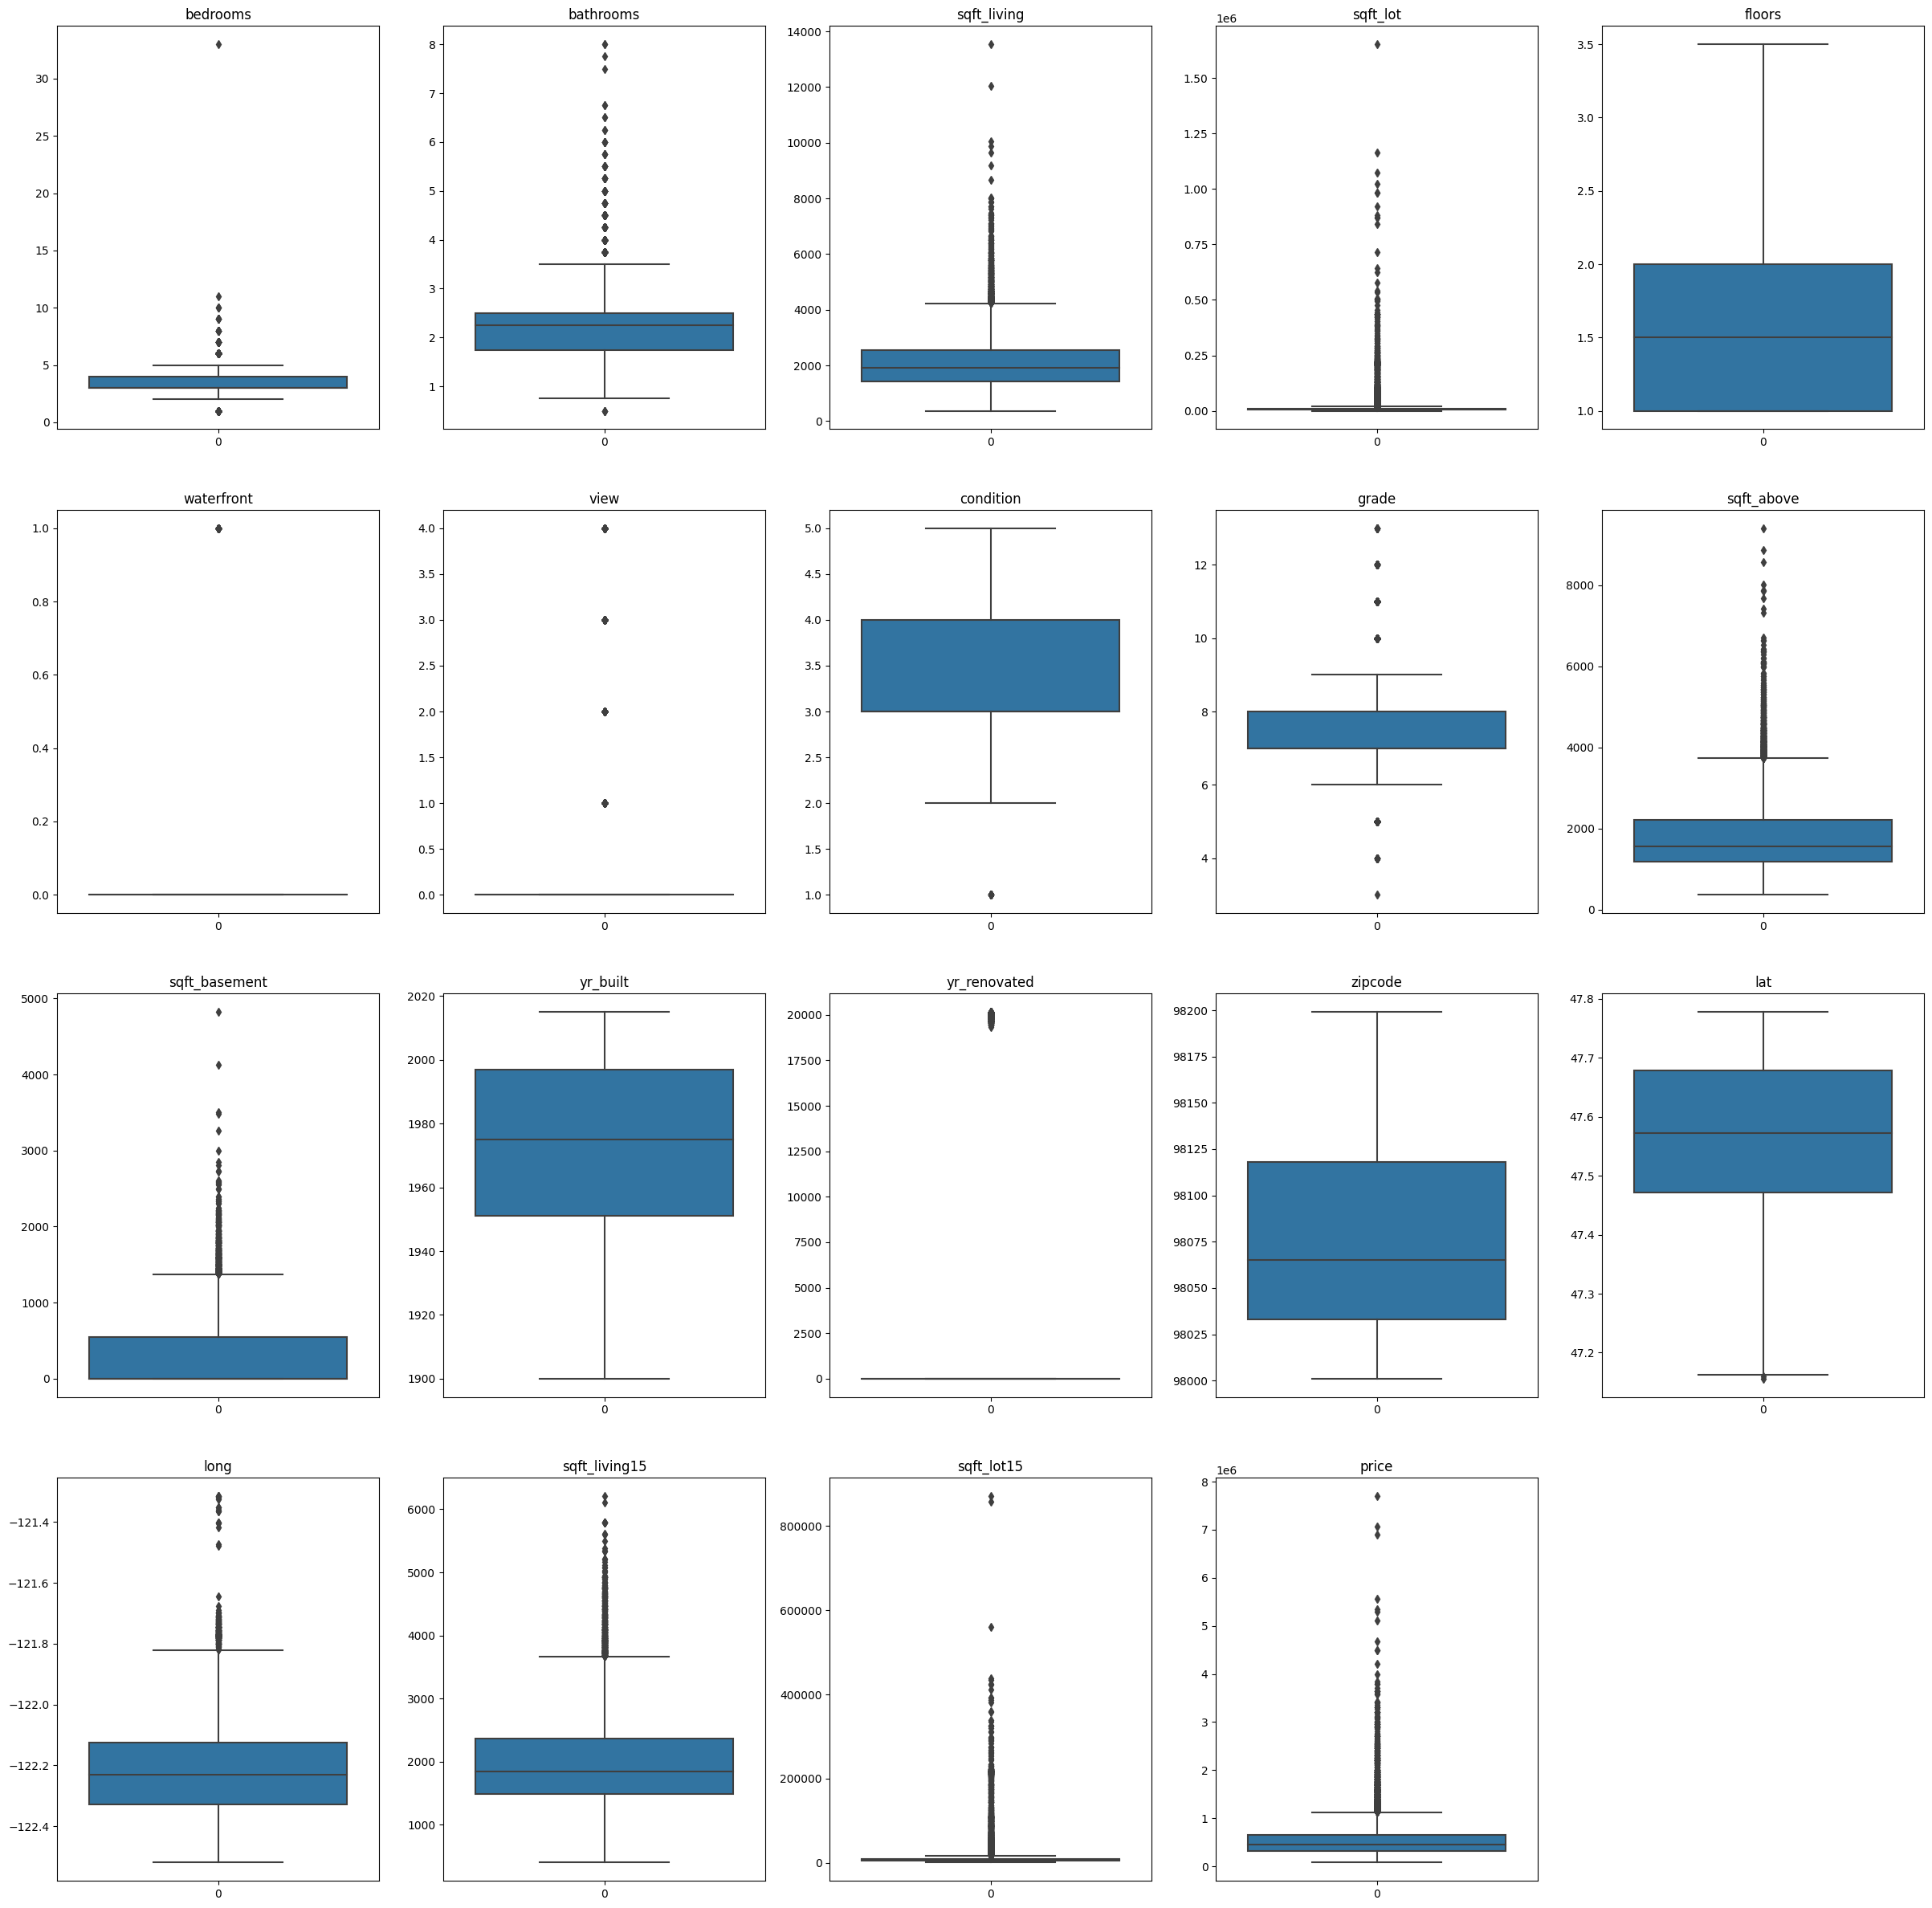

In [8]:
#3. investigating outliers with boxplots: there are a lot of outliers.. 
df_outliers = df_kch.drop(columns= ['id', 'date'])

plt.figure(figsize=(30, 30))
x = 1

for col in df_outliers.columns:
    plt.subplot(4, 5, x)
    sns.boxplot(df_outliers[col]).set(title=f'{col}')
    x+=1
plt.tight_layout
plt.show()

array([[<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'sqft_living'}>,
        <Axes: title={'center': 'sqft_lot'}>],
       [<Axes: title={'center': 'floors'}>,
        <Axes: title={'center': 'waterfront'}>,
        <Axes: title={'center': 'view'}>,
        <Axes: title={'center': 'condition'}>],
       [<Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'sqft_above'}>,
        <Axes: title={'center': 'sqft_basement'}>,
        <Axes: title={'center': 'yr_built'}>],
       [<Axes: title={'center': 'yr_renovated'}>,
        <Axes: title={'center': 'zipcode'}>,
        <Axes: title={'center': 'lat'}>,
        <Axes: title={'center': 'long'}>],
       [<Axes: title={'center': 'sqft_living15'}>,
        <Axes: title={'center': 'sqft_lot15'}>,
        <Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

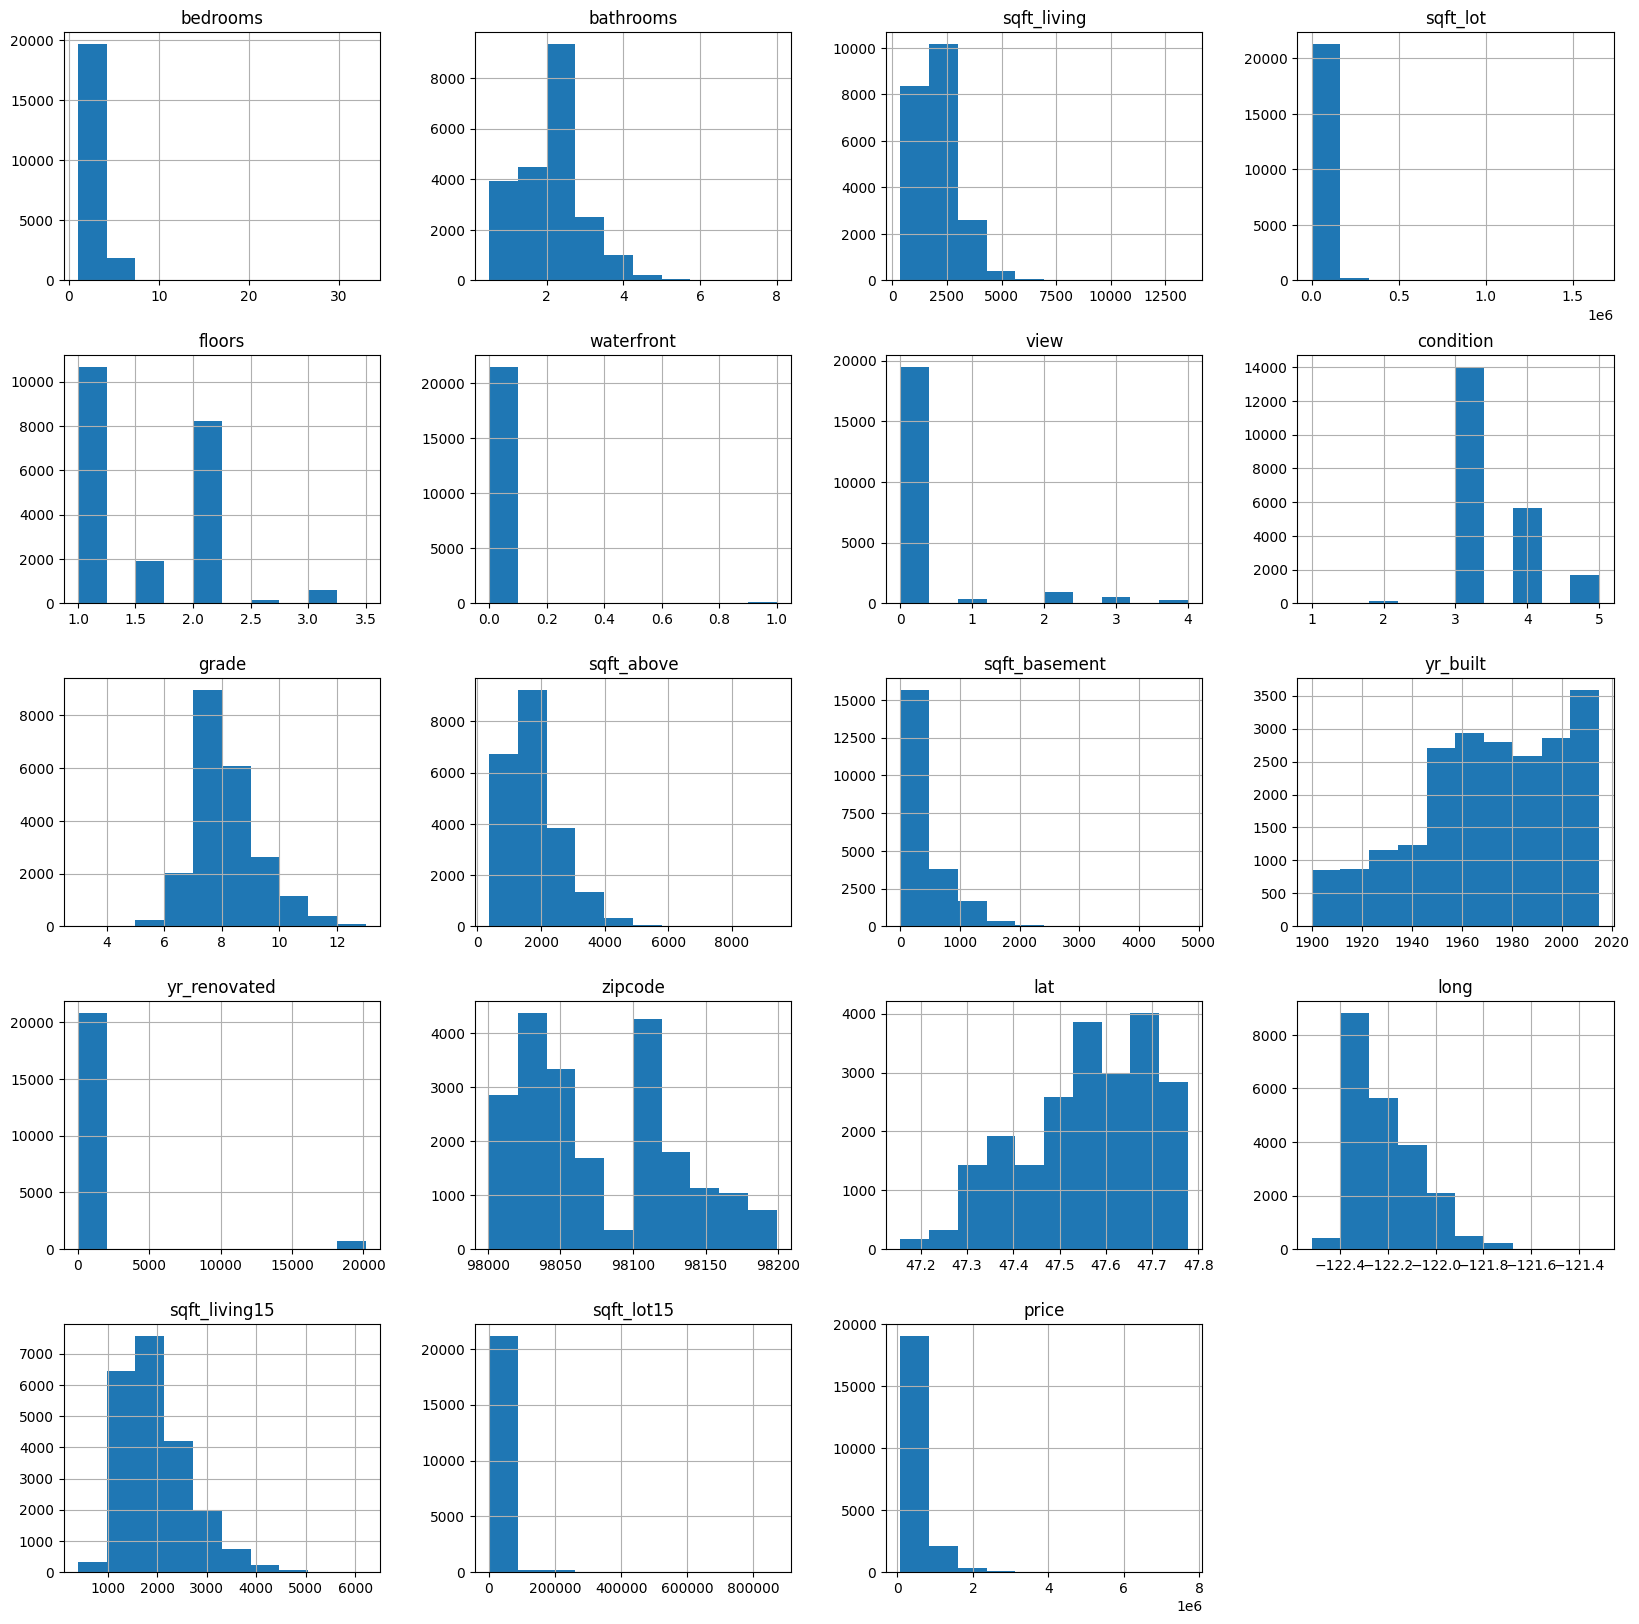

In [9]:
#Let's also have a look on the histograms of each variable.
#Maybe we dive deeper into the description and some statistics of the data first
df_outliers.hist(figsize=(20, 20))

In [10]:
#Let's examine the details here a bit. Interesting, max bedroom count is 33. Must be some kinda castle or just a deviation by mistake.
#Min bathroom is 0.5, didn't know that existed but apparently it does. Meaning it only has a toilet and a sink. Just google it.
#Seems like we only got very few houses with waterfront..
#Year renovated looks kinda weird and different than the other year column. Must be fixed.
#Wow, that one maximum price is way higher than the 75%ile. Maybe the price of the castle?
df_kch.describe()

id  bedrooms  bathrooms  sqft_living    sqft_lot    floors  \
count      21597.000 21597.000  21597.000    21597.000   21597.000 21597.000   
mean  4580474287.771     3.373      2.116     2080.322   15099.409     1.494   
std   2876735715.748     0.926      0.769      918.106   41412.637     0.540   
min      1000102.000     1.000      0.500      370.000     520.000     1.000   
25%   2123049175.000     3.000      1.750     1430.000    5040.000     1.000   
50%   3904930410.000     3.000      2.250     1910.000    7618.000     1.500   
75%   7308900490.000     4.000      2.500     2550.000   10685.000     2.000   
max   9900000190.000    33.000      8.000    13540.000 1651359.000     3.500   

       waterfront      view  condition     grade  sqft_above  sqft_basement  \
count   21597.000 21597.000  21597.000 21597.000   21597.000      21597.000   
mean        0.007     0.233      3.410     7.658    1788.597        285.749   
std         0.082     0.765      0.651     1.173     827.760        439.825   
min         0.000     0.000      1.000     3.000     370.000          0.000   
25%         0.000     0.000      3.000     7.000    1190.000          0.000   
50%         0.000     0.000      3.000     7.000    1560.000          0.000   
75%         0.000     0.000      4.000     8.000    2210.000        550.000   
max         1.000     4.000      5.000    13.000    9410.000       4820.000   

       yr_built  yr_renovated   zipcode       lat      long  sqft_living15  \
count 21597.000     21597.000 21597.000 21597.000 21597.000      21597.000   
mean   1971.000       687.582 98077.952    47.560  -122.214       1986.620   
std      29.375      3640.375    53.513     0.139     0.141        685.230   
min    1900.000         0.000 98001.000    47.156  -122.519        399.000   
25%    1951.000         0.000 98033.000    47.471  -122.328       1490.000   
50%    1975.000         0.000 98065.000    47.572  -122.231       1840.000   
75%    1997.000         0.000 98118.000    47.678  -122.125       2360.000   
max    2015.000     20150.000 98199.000    47.778  -121.315       6210.000   

       sqft_lot15       price  
count   21597.000   21597.000  
mean    12758.284  540296.574  
std     27274.442  367368.140  
min       651.000   78000.000  
25%      5100.000  322000.000  
50%      7620.000  450000.000  
75%     10083.000  645000.000  
max    871200.000 7700000.000

## Data Adjustments

Here I convert the data types to int where possible. Then I change the data type for the date column and then perform some calculation on the yr_renovated column since it needed some correction.

In [8]:
#Okay time to make some adjustments to the data:
# convert float columns without residue to int
def convert_to_int(column):
    if column.dtype == 'float64' and (column%1==0).all():
        return column.astype('int64')
    else:
        return column
    
df_kch = df_kch.apply(convert_to_int)

In [9]:
#change data type of date column to datetime
df_kch['date'] = pd.to_datetime(df_kch['date'], format='%Y-%m-%d')
# check "date" dtype
type(df_kch['date'][0])



pandas._libs.tslibs.timestamps.Timestamp

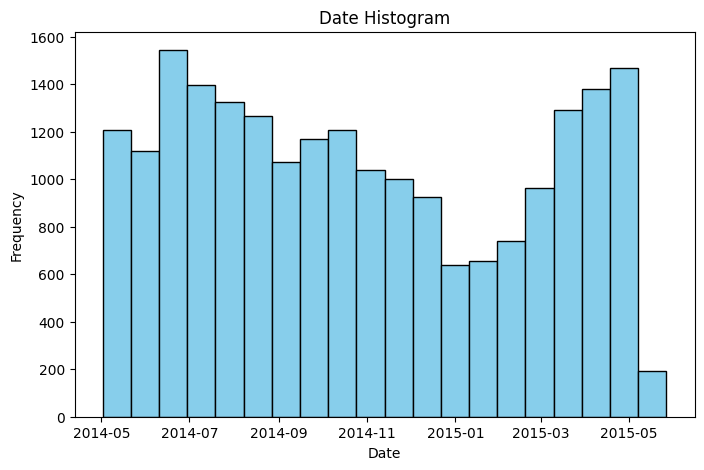

In [10]:
plt.hist(df_kch['date'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Date Histogram')
plt.show()

In [11]:
# .. and the values of the year renovated must be fixed
df_kch['yr_renovated'] = df_kch['yr_renovated'].apply(lambda x:x//10)

In [12]:
df_kch

id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      7129300520         3      1.000         1180      5650   1.000   
1      6414100192         3      2.250         2570      7242   2.000   
2      5631500400         2      1.000          770     10000   1.000   
3      2487200875         4      3.000         1960      5000   1.000   
4      1954400510         3      2.000         1680      8080   1.000   
...           ...       ...        ...          ...       ...     ...   
21592   263000018         3      2.500         1530      1131   3.000   
21593  6600060120         4      2.500         2310      5813   2.000   
21594  1523300141         2      0.750         1020      1350   2.000   
21595   291310100         3      2.500         1600      2388   2.000   
21596  1523300157         2      0.750         1020      1076   2.000   

       waterfront  view  condition  grade  ...  sqft_basement  yr_built  \
0               0     0          3      7  ...              0      1955   
1               0     0          3      7  ...            400      1951   
2               0     0          3      6  ...              0      1933   
3               0     0          5      7  ...            910      1965   
4               0     0          3      8  ...              0      1987   
...           ...   ...        ...    ...  ...            ...       ...   
21592           0     0          3      8  ...              0      2009   
21593           0     0          3      8  ...              0      2014   
21594           0     0          3      7  ...              0      2009   
21595           0     0          3      8  ...              0      2004   
21596           0     0          3      7  ...              0      2008   

       yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15  \
0                 0    98178 47.511 -122.257           1340        5650   
1              1991    98125 47.721 -122.319           1690        7639   
2                 0    98028 47.738 -122.233           2720        8062   
3                 0    98136 47.521 -122.393           1360        5000   
4                 0    98074 47.617 -122.045           1800        7503   
...             ...      ...    ...      ...            ...         ...   
21592             0    98103 47.699 -122.346           1530        1509   
21593             0    98146 47.511 -122.362           1830        7200   
21594             0    98144 47.594 -122.299           1020        2007   
21595             0    98027 47.535 -122.069           1410        1287   
21596             0    98144 47.594 -122.299           1020        1357   

            date   price  
0     2014-10-13  221900  
1     2014-12-09  538000  
2     2015-02-25  180000  
3     2014-12-09  604000  
4     2015-02-18  510000  
...          ...     ...  
21592 2014-05-21  360000  
21593 2015-02-23  400000  
21594 2014-06-23  402101  
21595 2015-01-16  400000  
21596 2014-10-15  325000  

[21597 rows x 21 columns]

## Data Exploration

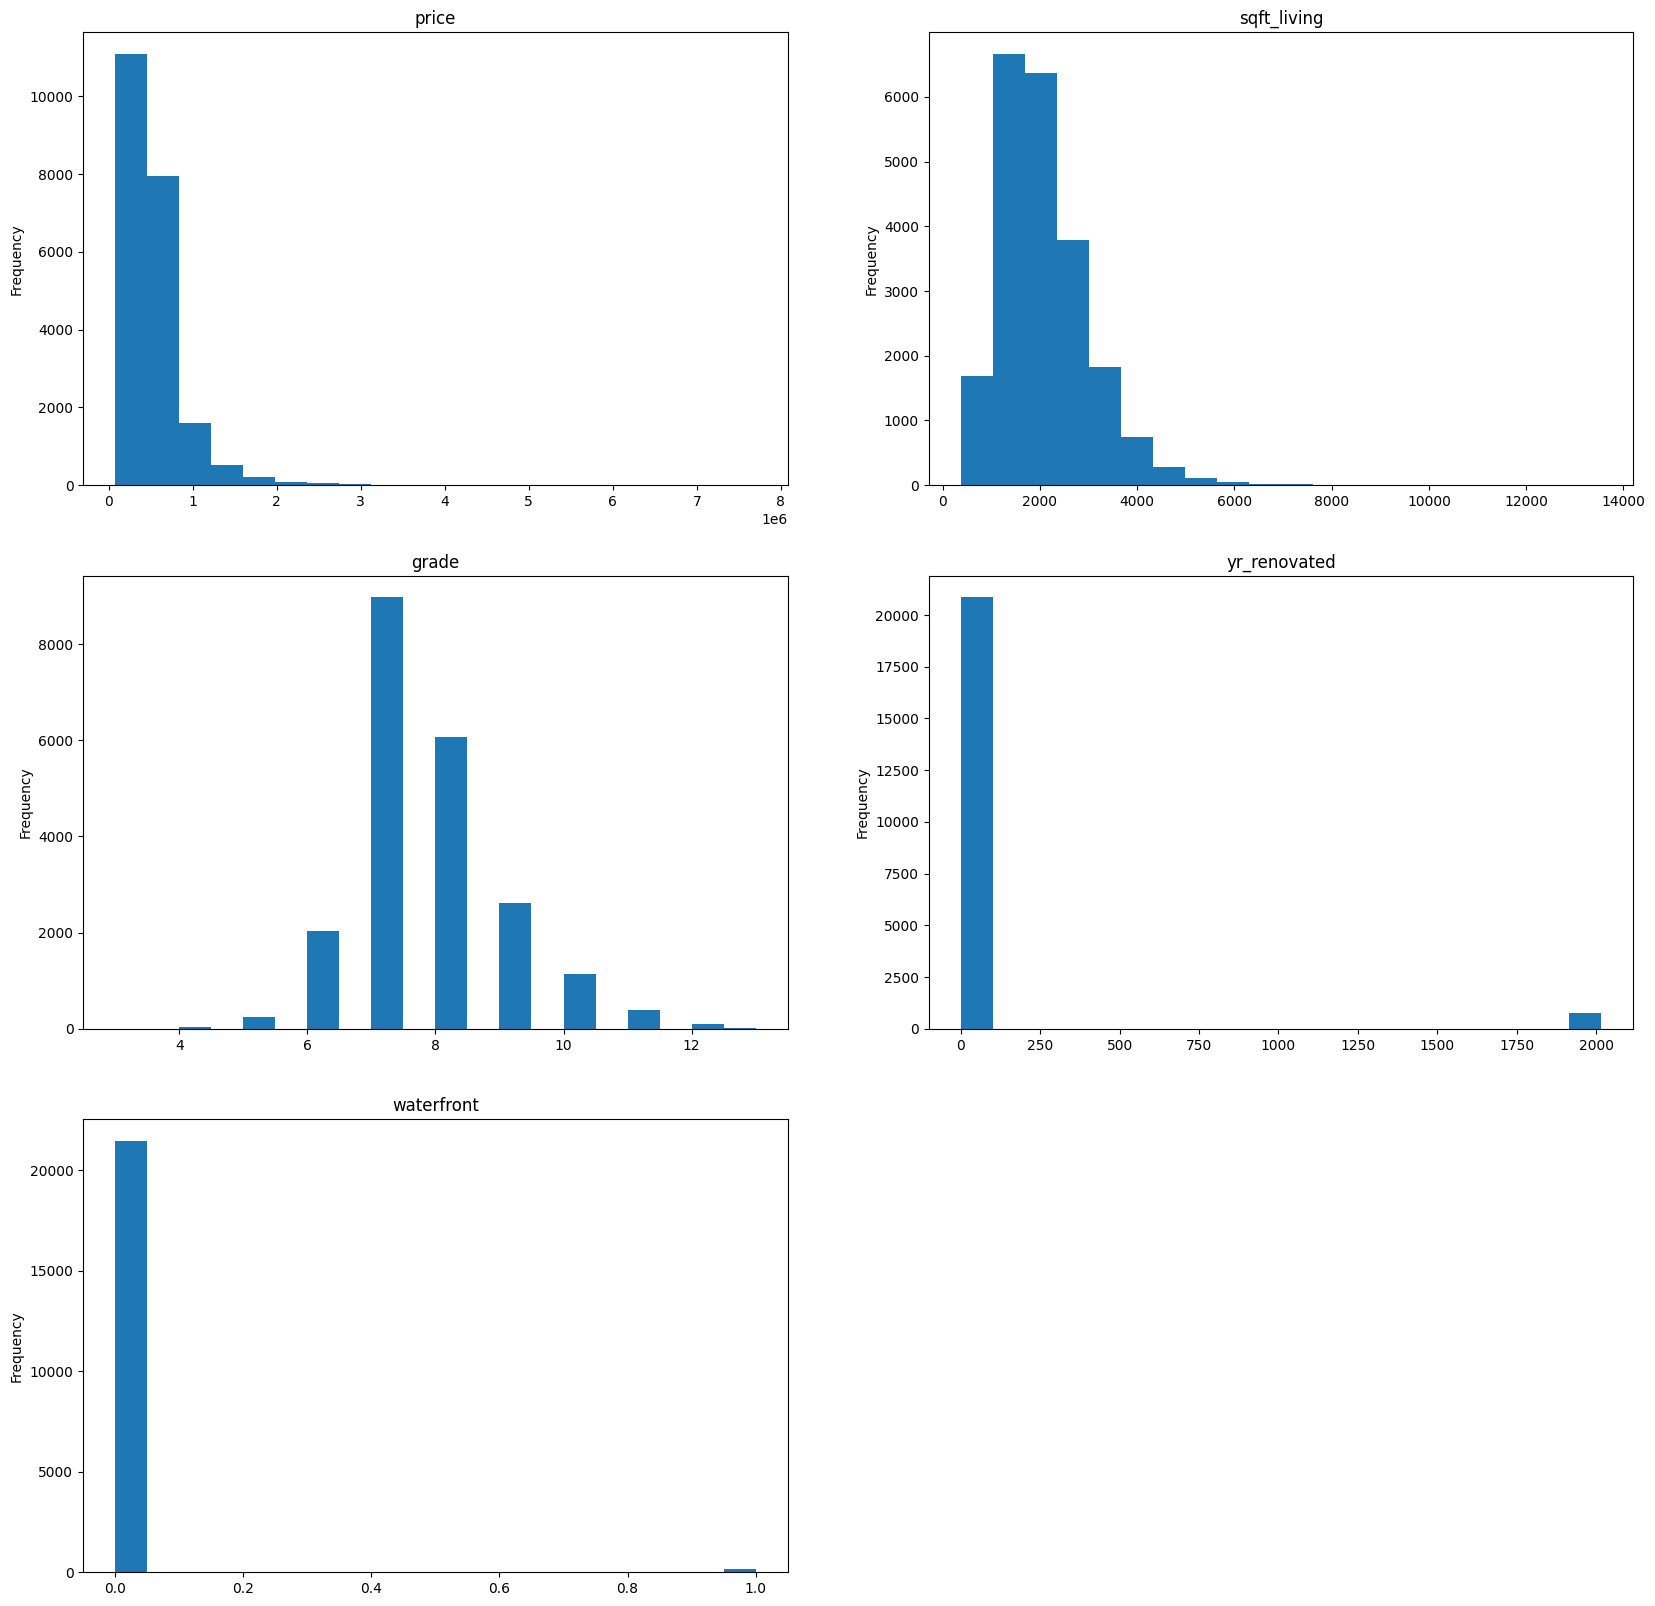

In [25]:
columns = ['price', 'sqft_living', 'grade', 'yr_renovated', 'waterfront']

plt.figure(figsize=(20, 20))
x = 1

for col in columns:
    plt.subplot(3, 2, x)
    df_kch[f'{col}'].plot.hist(bins=20).set_title(f'{col}')
    #plt.hist(df_kch[f'{col}'], bins=20)
    #plt.title(f'{col}')
    x+=1
plt.tight_layout
plt.show()

<Axes: >

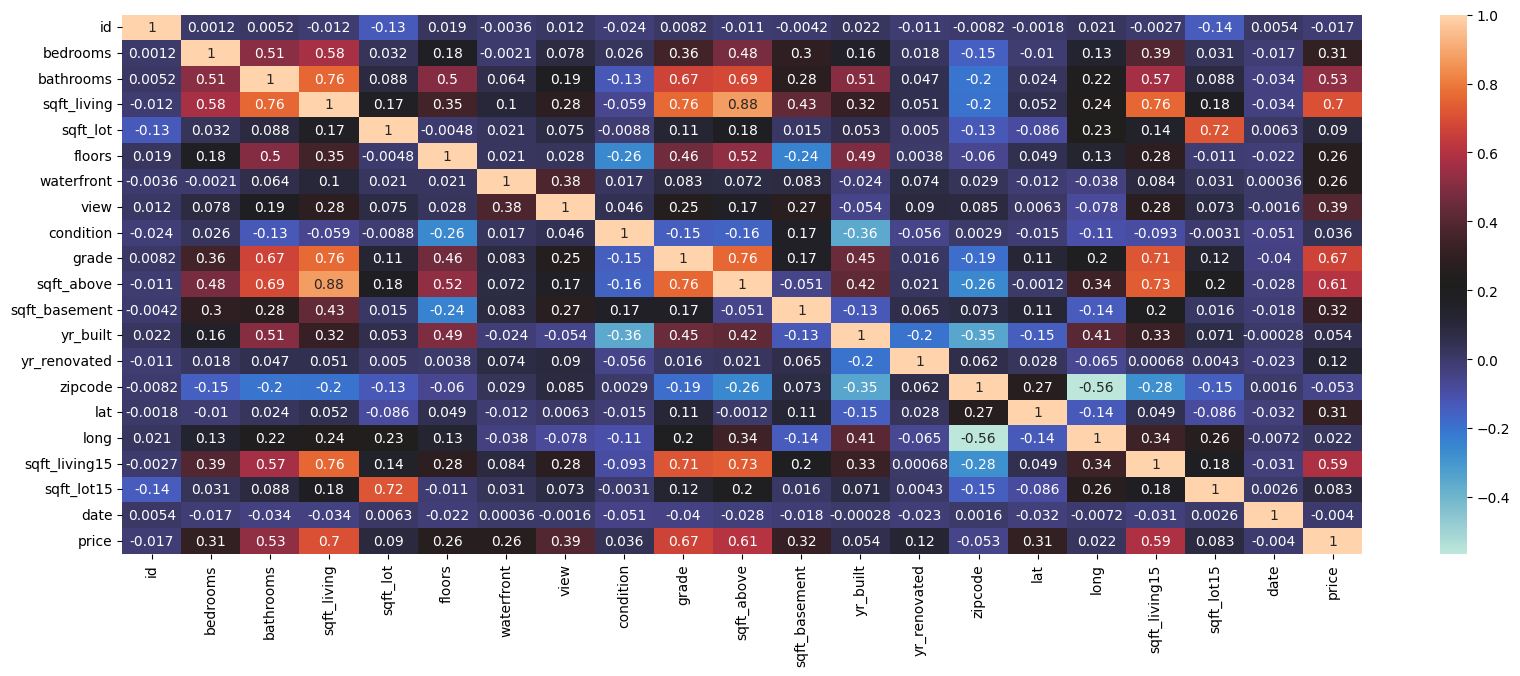

In [18]:
plt.figure(figsize = (20, 7))

sns.heatmap(df_kch.corr(), annot = True, cmap = 'icefire')

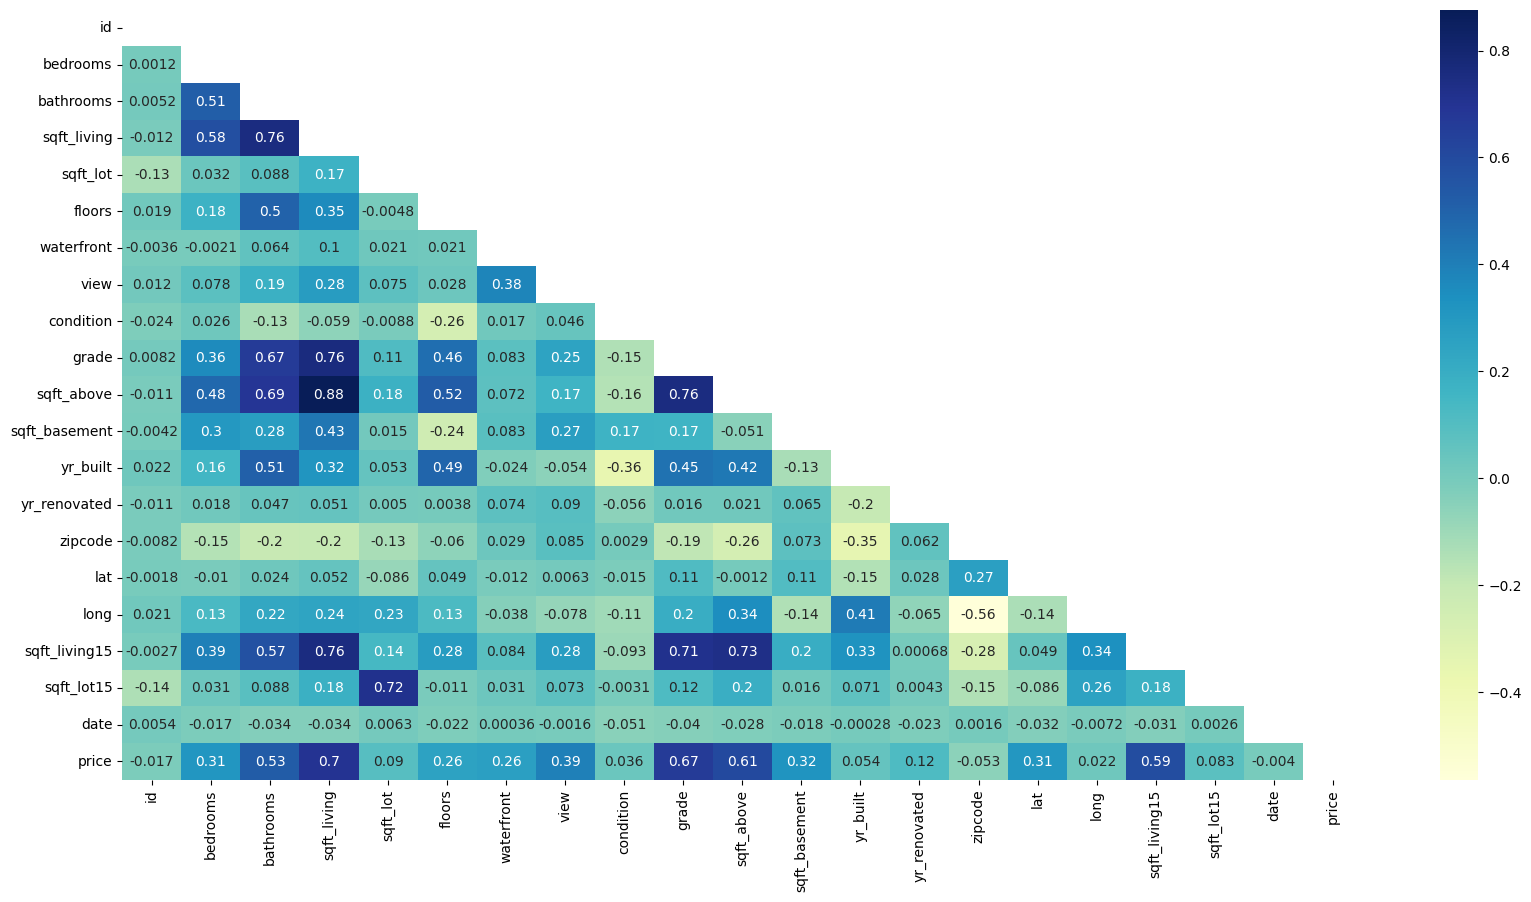

In [22]:
plt.figure(figsize=(20, 10))
mask = np.triu(np.ones_like(df_kch.corr()))
dataplot = sns.heatmap(df_kch.corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.tight_layout
plt.show()

In the heatmap we can see which attributes are positively correlated with the price:
1. sqft_living
2. grade
3. sqft_above
4. sqft_living15
5. bathrooms

All others are only slightly correlated to the pricing of a house. None of the columns has a strong negative correlation either.

Another interesting insight from the correlation heatmap is the relatively high value between grade and sqft_living15 (0.71).

## Answering Research Questions

Now let's do some investigation according to our research questions. 

1) Does the living space influence the price?
2) Does a waterfront have an impact on the price?
3) Does the location influence the price?

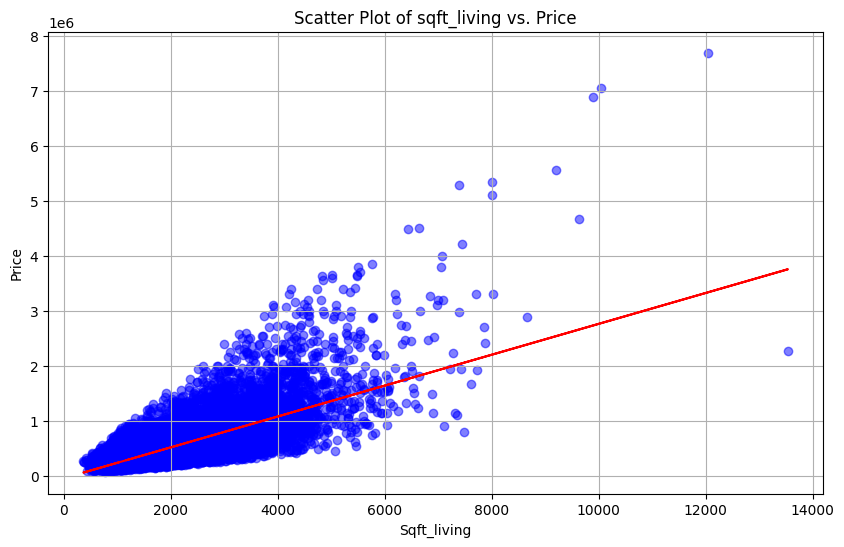

In [45]:
# Create a scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df_kch['sqft_living'], df_kch['price'], alpha=0.5, color='blue')

# Calculate the regression line
slope, intercept = np.polyfit(df_kch['sqft_living'], df_kch['price'], 1)
regression_line = slope * df_kch['sqft_living'] + intercept

# Plot the regression line
plt.plot(df_kch['sqft_living'], regression_line, color='red', label='Regression Line')

plt.title('Scatter Plot of sqft_living vs. Price')
plt.xlabel('Sqft_living')
plt.ylabel('Price')
plt.grid(True)

# Show the plot
plt.show()

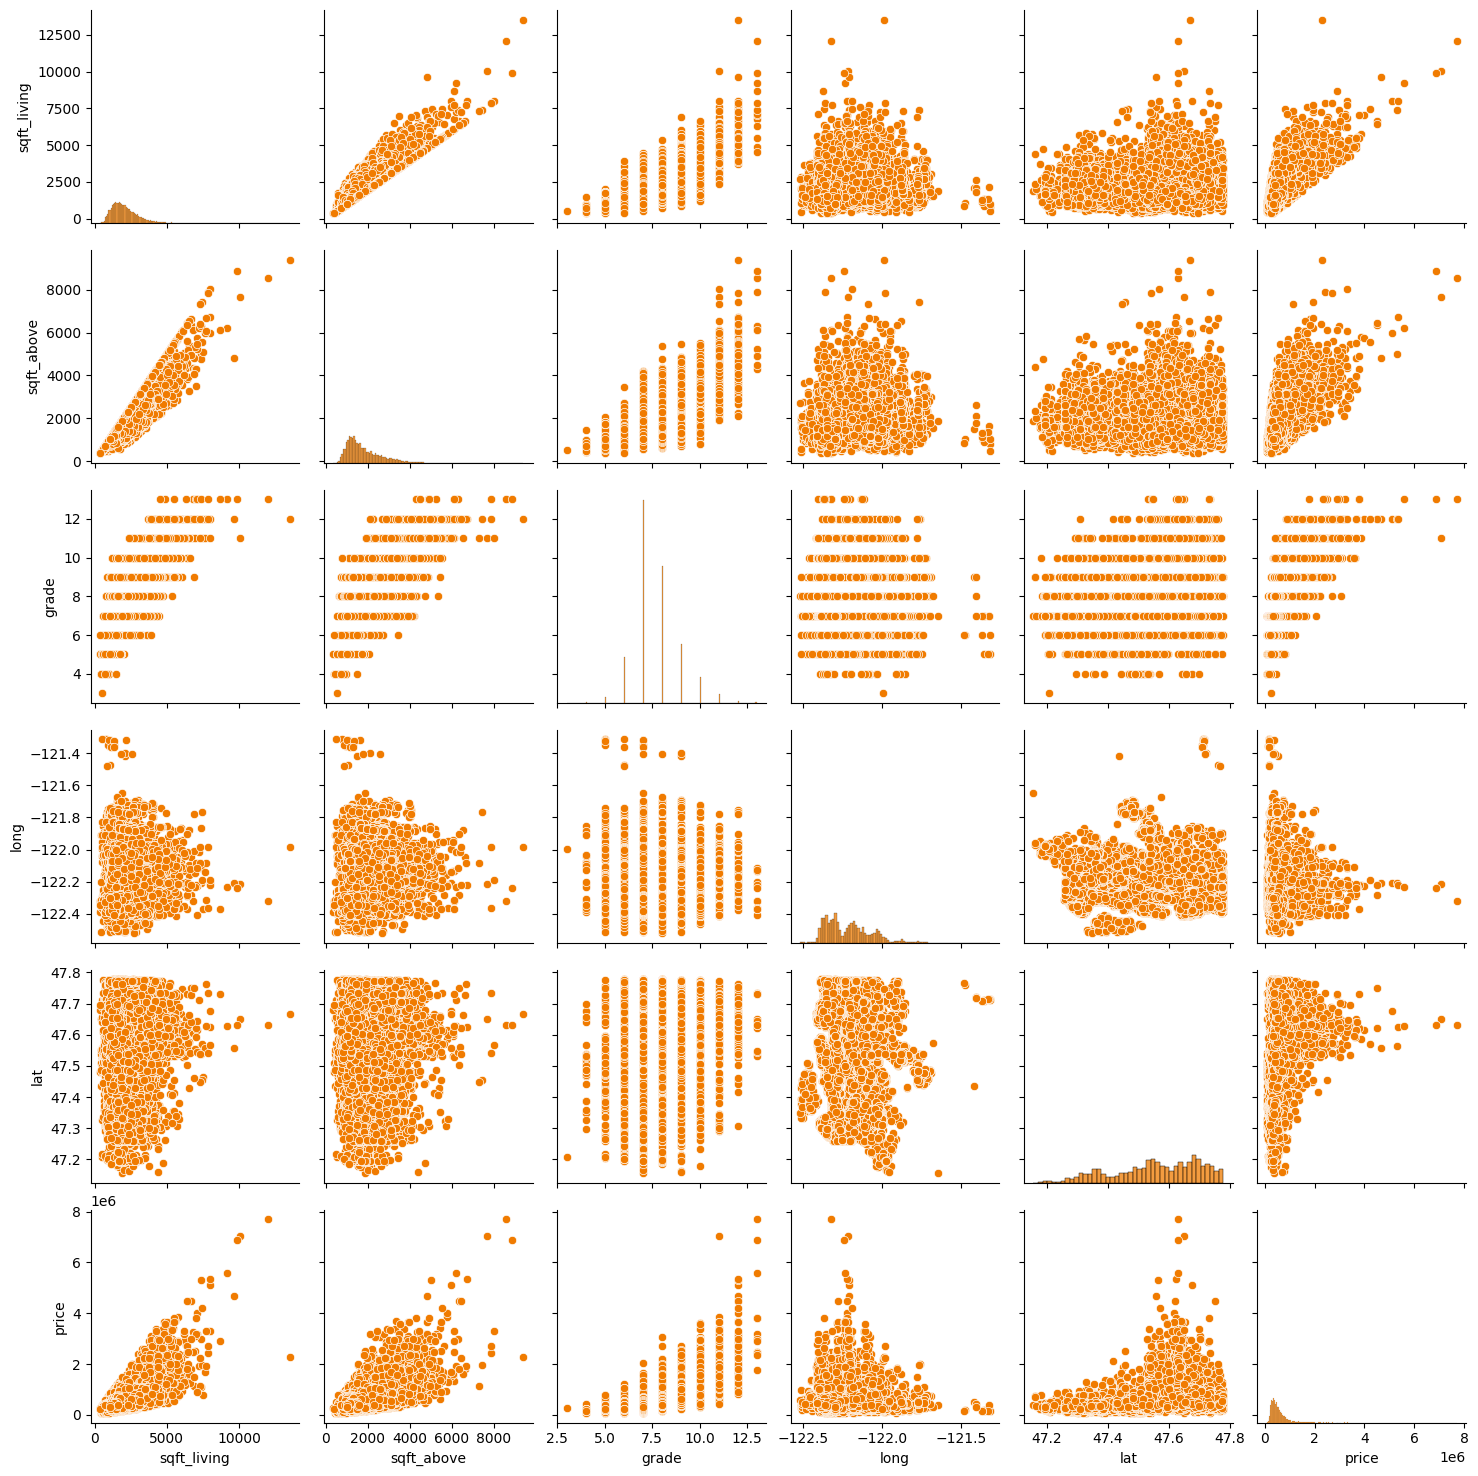

In [66]:
sns.pairplot(df_kch[['sqft_living', 'sqft_above', 'grade', 'long', 'lat', 'price']])

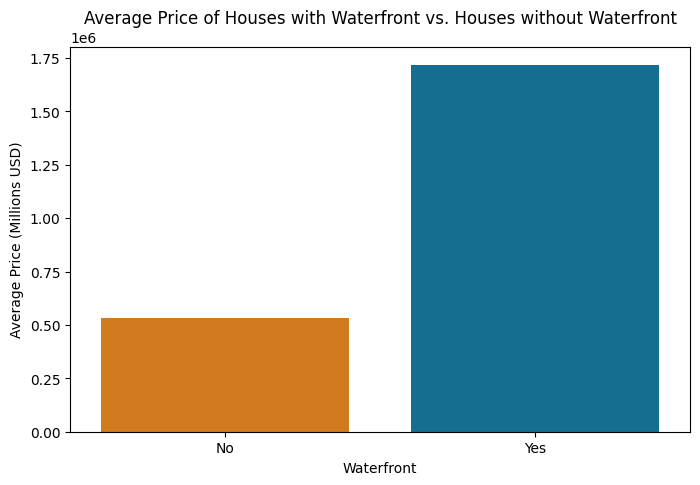

In [53]:
# Define a custom color palette
custom_palette = {'No': '#f07b00', 'Yes': '#0076a5'}

# Set the custom color palette
sns.set_palette(sns.color_palette(list(custom_palette.values())))

ax = sns.barplot(x='waterfront', y='price', data=df_kch, ci=None)

ax.set_xticklabels(["No", "Yes"])

plt.xlabel("Waterfront")
plt.ylabel("Average Price (Millions USD)")
plt.title("Average Price of Houses with Waterfront vs. Houses without Waterfront")

plt.show()

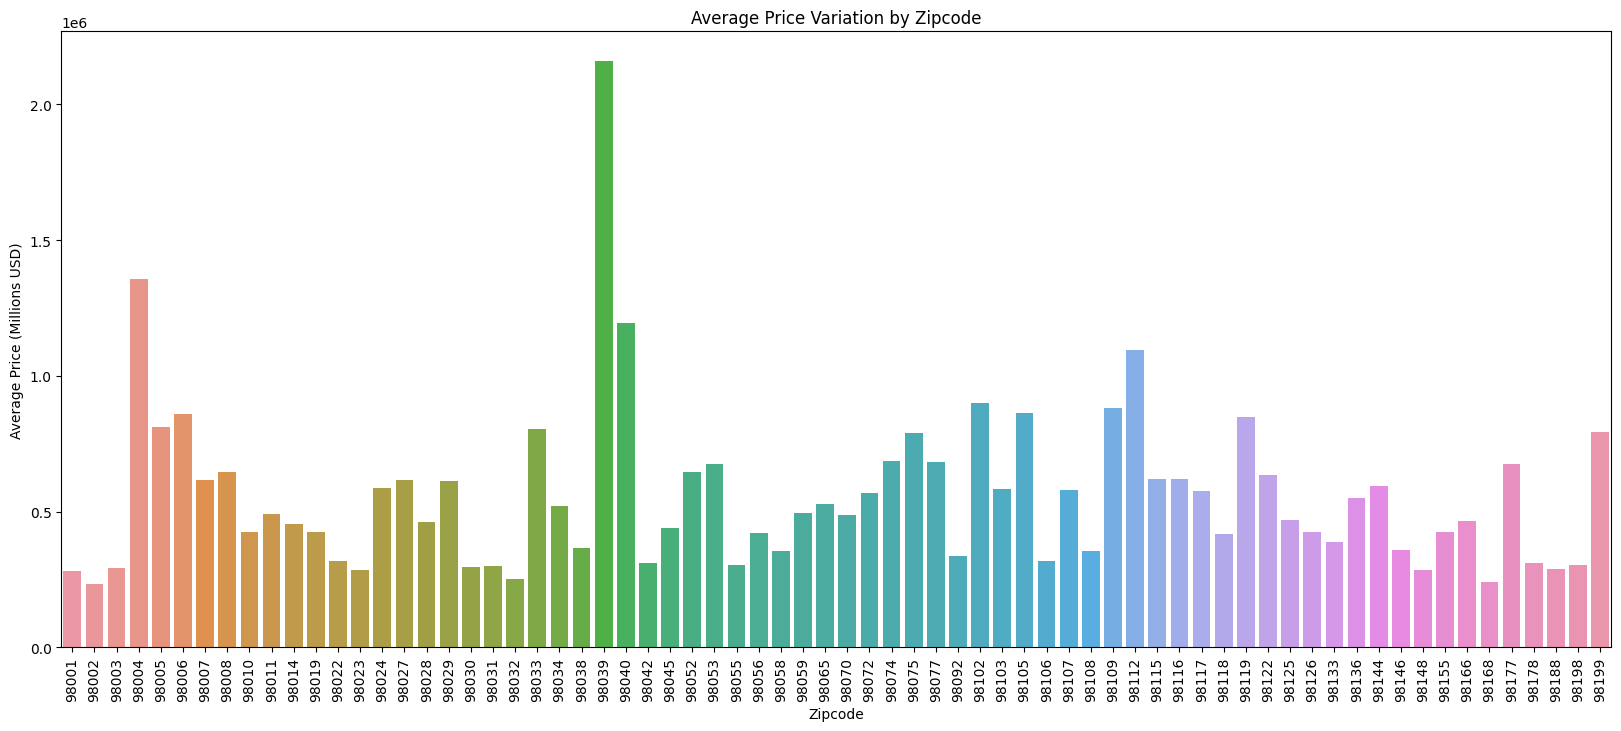

In [41]:
#relation of the neighborhood(indicated by zipcode) on the price
plt.figure(figsize=(20,8))

sns.barplot(x=df_kch['zipcode'], y=df_kch['price'], ci=None)
plt.xlabel('Zipcode')
plt.ylabel('Average Price (Millions USD)')
plt.title('Average Price Variation by Zipcode')
plt.xticks(rotation=90)
plt.show()

In [54]:
import plotly.express as px
# Create a heatmap using Plotly Express
fig = px.density_mapbox(df_kch, lat='lat', lon='long', z='price', radius=10)

# Customize the map layout
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": 47.6, "lon": -122.3},
    mapbox_zoom=9,
    height=800,
    width=1000 
)

fig.show()

In [67]:
# Create a choropleth map using Plotly Express

fig = px.choropleth_mapbox(df_kch,
                           locations='zipcode',
                           geojson='https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/wa_washington_zip_codes_geo.min.json',
                           color='price',
                           featureidkey='properties.ZCTA5CE10',
                           title='Average house prices per zipcode area',
                           mapbox_style='open-street-map',
                           center={"lat": df_kch['lat'].mean(), "lon": df_kch['long'].mean()},
                           height=600,
                           width=800)
fig.show()


I searched for some city names to the respective zipcodes on the internet and want to include them in my dataset. Then I want to additionally display them in the tooltip on my choropleth mapbox.

In [58]:
city_zip_data = pd.read_csv('data/zipcodes_names_kingcounty.csv')
city_zip_data = city_zip_data[city_zip_data['COUNTY_NAME'].str.contains('King County')]

In [59]:
city_zip_data.columns = city_zip_data.columns.str.lower()
city_zip_data.drop(columns=['objectid', 'zip', 'county', 'zip_type', 'county_name', 'shape_length', 'shape_area'], inplace=True)
city_zip_data = city_zip_data.rename(columns={'preferred_city': 'city'})
city_zip_data

zipcode         city
0      98001       AUBURN
1      98002       AUBURN
2      98003  FEDERAL WAY
3      98004     BELLEVUE
4      98005     BELLEVUE
..       ...          ...
100    98199      SEATTLE
108    98224       BARING
118    98288    SKYKOMISH
147    98354       MILTON
181    98422       TACOMA

[87 rows x 2 columns]

In [60]:
merged_data = df_kch.merge(city_zip_data, on='zipcode', how='left')
merged_data

id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      7129300520         3      1.000         1180      5650   1.000   
1      6414100192         3      2.250         2570      7242   2.000   
2      5631500400         2      1.000          770     10000   1.000   
3      2487200875         4      3.000         1960      5000   1.000   
4      1954400510         3      2.000         1680      8080   1.000   
...           ...       ...        ...          ...       ...     ...   
21592   263000018         3      2.500         1530      1131   3.000   
21593  6600060120         4      2.500         2310      5813   2.000   
21594  1523300141         2      0.750         1020      1350   2.000   
21595   291310100         3      2.500         1600      2388   2.000   
21596  1523300157         2      0.750         1020      1076   2.000   

       waterfront  view  condition  grade  ...  yr_built  yr_renovated  \
0               0     0          3      7  ...      1955             0   
1               0     0          3      7  ...      1951          1991   
2               0     0          3      6  ...      1933             0   
3               0     0          5      7  ...      1965             0   
4               0     0          3      8  ...      1987             0   
...           ...   ...        ...    ...  ...       ...           ...   
21592           0     0          3      8  ...      2009             0   
21593           0     0          3      8  ...      2014             0   
21594           0     0          3      7  ...      2009             0   
21595           0     0          3      8  ...      2004             0   
21596           0     0          3      7  ...      2008             0   

       zipcode    lat     long  sqft_living15  sqft_lot15       date   price  \
0        98178 47.511 -122.257           1340        5650 2014-10-13  221900   
1        98125 47.721 -122.319           1690        7639 2014-12-09  538000   
2        98028 47.738 -122.233           2720        8062 2015-02-25  180000   
3        98136 47.521 -122.393           1360        5000 2014-12-09  604000   
4        98074 47.617 -122.045           1800        7503 2015-02-18  510000   
...        ...    ...      ...            ...         ...        ...     ...   
21592    98103 47.699 -122.346           1530        1509 2014-05-21  360000   
21593    98146 47.511 -122.362           1830        7200 2015-02-23  400000   
21594    98144 47.594 -122.299           1020        2007 2014-06-23  402101   
21595    98027 47.535 -122.069           1410        1287 2015-01-16  400000   
21596    98144 47.594 -122.299           1020        1357 2014-10-15  325000   

            city  
0        SEATTLE  
1        SEATTLE  
2        KENMORE  
3        SEATTLE  
4      SAMMAMISH  
...          ...  
21592    SEATTLE  
21593    SEATTLE  
21594    SEATTLE  
21595   ISSAQUAH  
21596    SEATTLE  

[21597 rows x 22 columns]

Now we will be able to see the city names on the tooltips as well. Have a look!

In [68]:
fig = px.choropleth_mapbox(merged_data,
                           locations='zipcode',
                           geojson='https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/wa_washington_zip_codes_geo.min.json',
                           color='price',
                           hover_name='city',
                           featureidkey='properties.ZCTA5CE10',
                           title='Average house prices per zipcode area',
                           mapbox_style='open-street-map',
                           center={"lat": df_kch['lat'].mean(), "lon": df_kch['long'].mean()},
                           height=600,
                           width=800)
fig.show()

Here I want to show how the prices scatter over the latitude and longitude. The prices get higher the more you move to the north (latitude) and higher the more to the west (longitude). So higher prices allocate in general towards north-west.

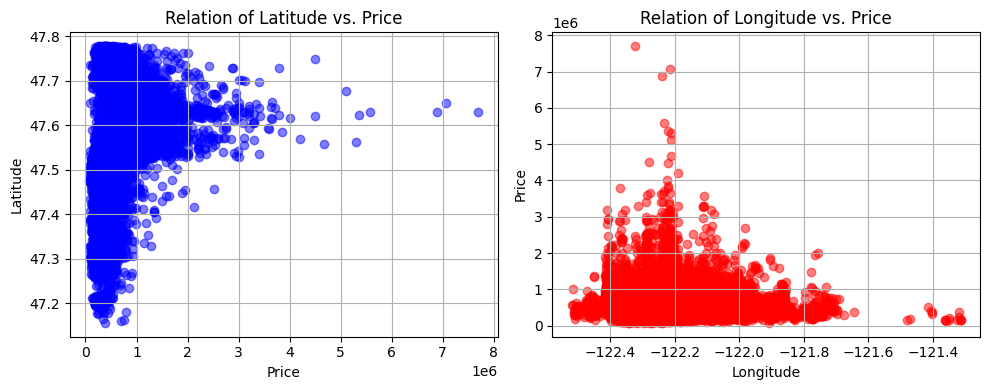

In [73]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot for latitude vs. price
axes[0].scatter(df_kch['price'], df_kch['lat'], alpha=0.5, color='blue')
axes[0].set_title('Relation of Latitude vs. Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Latitude')
axes[0].grid(True)

# Scatter plot for longitude vs. price
axes[1].scatter(df_kch['long'], df_kch['price'], alpha=0.5, color='red')
axes[1].set_title('Relation of Longitude vs. Price')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Price')
axes[1].grid(True)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

This was some extra, where I wanted to categorize the grade into three groups using pd.cut(). It worked but I didn't use it in the end. Anyways, will leave it here in case I want to look it up some time.

Ah and also added a new column with price/sqft, but didn't need it as well since my client wanted to show off anyway and wasn't really caring about the cost-benefit-ratio.

In [23]:
#create grouping based on grade description in documentation
bin_quality =[1,5,10,13]
label = ['Low', 'Average', 'High']

df_kch['quality'] = pd.cut(df_kch['grade'], bins = bin_quality, labels = label)
df_kch.head()

#create price/sqft column using the lotsize
df_kch['price_per_sqft'] = df_kch['price']/df_kch['sqft_lot']
df_kch.head()

id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  7129300520         3      1.000         1180      5650   1.000           0   
1  6414100192         3      2.250         2570      7242   2.000           0   
2  5631500400         2      1.000          770     10000   1.000           0   
3  2487200875         4      3.000         1960      5000   1.000           0   
4  1954400510         3      2.000         1680      8080   1.000           0   

   view  condition  grade  ...  yr_renovated  zipcode    lat     long  \
0     0          3      7  ...             0    98178 47.511 -122.257   
1     0          3      7  ...          1991    98125 47.721 -122.319   
2     0          3      6  ...             0    98028 47.738 -122.233   
3     0          5      7  ...             0    98136 47.521 -122.393   
4     0          3      8  ...             0    98074 47.617 -122.045   

   sqft_living15  sqft_lot15       date   price  quality price_per_sqft  
0           1340        5650 2014-10-13  221900  Average         39.274  
1           1690        7639 2014-12-09  538000  Average         74.289  
2           2720        8062 2015-02-25  180000  Average         18.000  
3           1360        5000 2014-12-09  604000  Average        120.800  
4           1800        7503 2015-02-18  510000  Average         63.119  

[5 rows x 23 columns]

## Picking a house for Jennifer Montgomery

Now let's start inspecting some house candidates for Jennifer Montgomery. She wants a waterfront, a renovated house and a grade greater than 10.

First let's get an overview where the waterfront houses are and how they are priced. The bigger the size of the dots the higher their price. This is missing in the legend but I didn't know how to include it.

In [76]:
# Create a scatter plot on a Mapbox map
df_kch['custom_color'] = df_kch['waterfront'].apply(lambda x: 'no waterfront' if x == 0 else 'waterfront')

fig = px.scatter_mapbox(df_kch, 
                        lat='lat',   # Specify the latitude column
                        lon='long',  # Specify the longitude column
                        color='custom_color', 
                        size='price',
                        title='Prices colored according to waterfront',
                        #hover_name='city',    # Tooltip information
                        zoom=10, width=800, height=600)  # Adjust the zoom level 

# Customize the map layout
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(mapbox_center={"lat": 47.6, "lon": -122.3})


# Show the map
fig.show()

In [13]:
df_reqs = df_kch.query('waterfront == 1 and yr_renovated != 0 and grade > 10')
df_reqs[['id', 'yr_renovated', 'lat', 'long', 'zipcode', 'price']]

id  yr_renovated    lat     long  zipcode    price
3910   9808700762          2001 47.650 -122.214    98004  7060000
8085   1924059029          2009 47.557 -122.210    98040  4670000
15678  6117502230          1990 47.442 -122.354    98166  1640000
18185  3625059152          1987 47.608 -122.110    98008  3300000

In [81]:
# Create a scatter plot on a Mapbox map
#df_reqs['custom_color'] = df_reqs['waterfront'].apply(lambda x: 'no waterfront' if x == 0 else 'waterfront')

fig = px.scatter_mapbox(df_reqs, 
                        lat='lat',   # Specify the latitude column
                        lon='long',  # Specify the longitude column
                        #color='red', 
                        size='price',
                        title='Property candidates for Jennifer Montgomery',
                        #hover_name='city',    # Tooltip information
                        zoom=10, width=800, height=600)  # Adjust the zoom level 

# Customize the map layout
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(mapbox_center={"lat": 47.6, "lon": -122.3})


# Show the map
fig.show()

The priciest house is the biggest dot located in Bellevue. The second option is the one on Mercer Island. 